# Introduction

> Image captioning is the task of generating textual descriptions of a given image, requiring  techniques of computer vision and natural language processing.

It is a popular research area of Artificial Intelligence that deals with image understanding and a language description for that image. Generating well-formed sentences requires both syntactic and semantic understanding of the language. Being able to describe the content of an image using accurately formed sentences is a very challenging task, but it could also have a great impact, by helping visually impaired people better understand the content of images.  [source](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/) 

Here, I have used [COCO Dataset 2017](https://cocodataset.org/#download) which contains **12 different types of categories** and among them it has **80 types of sub-categories**. Each sub categories contain list of images and five captions to each image.

In [ ]:
# !pip install pycocotools

from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers.merge import add

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Exploring COCO Dataset

#### Initialize COCO class and operate instances_train2017.json

In [ ]:
coco=COCO("../input/cocods/annotations_trainval2017/annotations/instances_train2017.json")

#### Find Categories

In [ ]:
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

#### Find Sub Categories

In [ ]:
subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

#### Find Sub categories with its corresponding IDs

In [ ]:
catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

#### Find total images with each sub categories

In [ ]:
subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds: 
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img
    
print("Sub categories with Image IDs :",len(subcategories_imageIds))

In [ ]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in each sub categories: ", length_dict)

In [ ]:
#subcategories_imageIds['bicycle']

Here, I have selected two sub categories **Bicycle** and **Airplane** for accomplishing image caption generator project.

In [ ]:
train_cats = subcategories_imageIds['bicycle'] + subcategories_imageIds['airplane']
imgIdss = coco.getImgIds(imgIds = train_cats)
print("Total Images: ", len(imgIdss))

#### Load some of the random images

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

#### Load some of the random images with segmented objects inside them 

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    # print(anns)
    coco.showAnns(anns)
    

plt.show()

#### Load images with keypoints objects

In [ ]:
annFile = "../input/cocods/annotations_trainval2017/annotations/person_keypoints_train2017.json"
coco_kps=COCO(annFile)

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    

plt.show()

#### Load images with respective captions

In [ ]:
annFile = "../input/cocods/annotations_trainval2017/annotations/captions_train2017.json"
coco_caps=COCO(annFile)

In [ ]:
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

In [ ]:
img = coco.loadImgs(next_pix[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

In [ ]:
img = coco.loadImgs(next_pix[10])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

# Image caption generator
#### Here I have taken "Bicycle" and "Airplane" images and captions only.


In [ ]:
print("Total images for training: ", len(imgIdss))

# Prepare Dataset 

#### Group all captions together having the same image and store them in dict.

In [ ]:
dataset = dict()
imgcaptions = []

for imgid in imgIdss:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
        # Replace - to blank
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]
        
        # join word list into sentence and <start> and <end> tag to each sentence which helps 
        # LSTM encoder-decoder model while training.
        
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
    
print("Length of Dataset: ",len(dataset))
print(dataset['http://images.cocodataset.org/train2017/000000047084.jpg'])
#dataset

# Preprocess and tokenize the captions

In [ ]:
from itertools import chain
flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)
print("Bicycle ID: ", tokenizer.word_index['bicycle'])
print("Airplane ID: ", tokenizer.word_index['airplane'])

# print(tokenizer.word_index)

# Preprocess and caching the features extracted from InceptionV3

I will use InceptionV3 (which is pretrained on Imagenet) to classify each image. I will extract features from the last convolutional layer. This is also called a tranfer learning.

Since the Xception model was originally built for **imagenet**, we will do little changes for integrating with our model. Here, the Xception model takes **100 x 100 x 3** image size as input. We will remove the last classification layer and get the **2048 feature vector**.

In [ ]:
model = Xception(include_top=False, pooling='avg')

image_features = {}

for img in tqdm(dataset.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Resize each image size 299 x 299
    image = cv2.resize(image,(299,299))
    image = np.expand_dims(image, axis=0)
    
    # Normalize image pixels
    image = image/127.5
    image = image - 1.0

    # Extract features from image
    feature = model.predict(image)
    image_features[img] = feature
    
print("Image features length: ", len(image_features))

In [ ]:
image_features['http://images.cocodataset.org/train2017/000000047084.jpg'].shape

Here, I have found the max_length among the captions which will help to pad each caption with the same length.

In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

# Make a Data Generator

We have to train our model on 6221 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6221 images is not possible to hold into memory so we will be using a generator method that will yield batches.

**The generator will yield the input and output sequence.**

##### For example:

The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

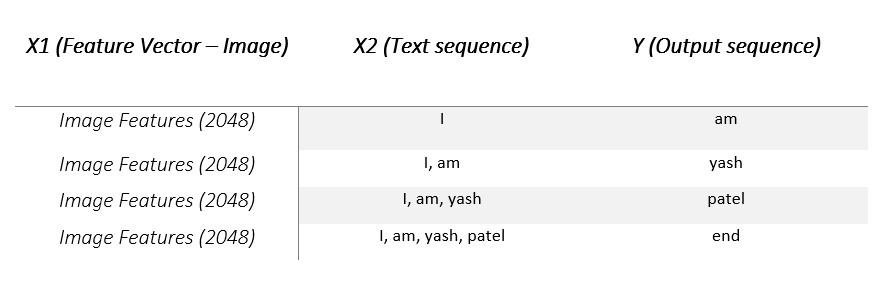

In [ ]:
#create input-output sequence pairs from the image description.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)


# Define CNN-LSTM Model

#### CNN (Convolution Neural Network)

Technically, deep learning CNN models to train and test, each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply Softmax function to classify an object with probabilistic values between 0 and 1.


#### [Click here](https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/) to know more about CNN.

<br>

#### LSTM (Long short-term memory)


Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning


#### [Click here](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/) to know more about LSTM.


# Model Architechture 

### CNN-LSTM model:

- CNN is used for extracting features from the image. We will use the pre-trained model Xception.
- LSTM will use the information from CNN to help generate a description of the image.


### Model structure

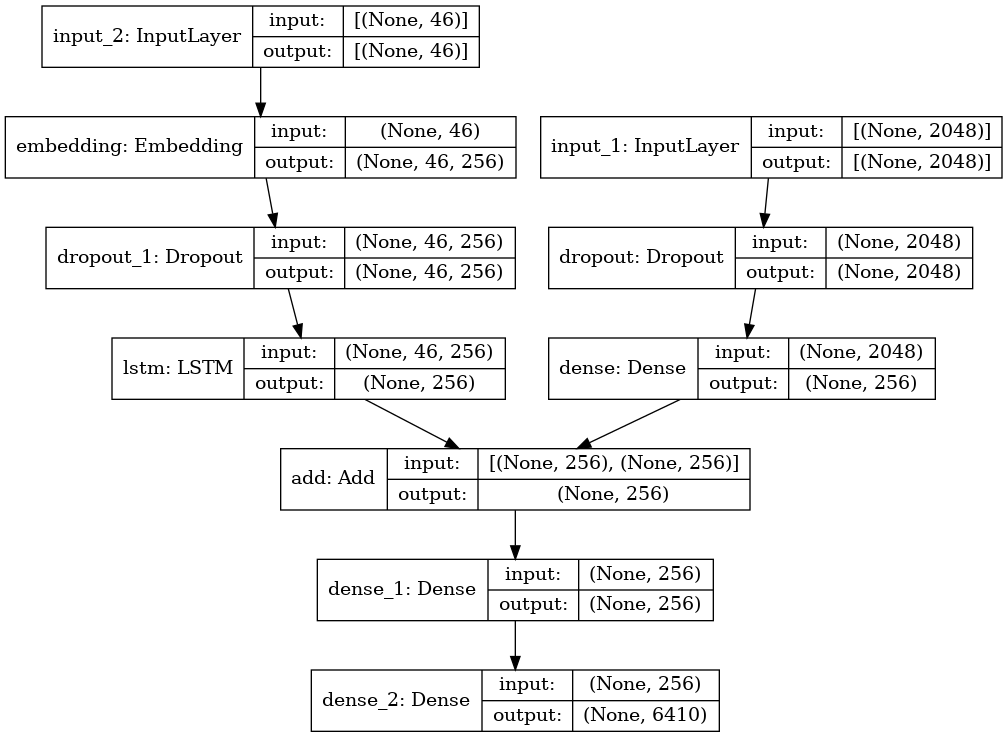


* The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.<br> 
* An embedding layer will handle the text input,followed by the LSTM layer.
<br>
* Then By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.

In [ ]:
from keras.utils import plot_model

# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [ ]:
# train our model
print('Dataset: ', len(dataset))
print('Descriptions: train=', len(dataset))
print('Photos: train=', len(image_features))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

model = define_model(total_words, max_length)
epochs=1
steps = len(dataset)

# making a directory models to save our models
import os
os.mkdir("models")

for i in range(epochs):
    generator = data_generator(dataset, image_features, tokenizer, max_length)
    model.fit(generator, epochs=5, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


img_paths = ["../input/cocods/val2017/val2017/000000001761.jpg",
            "../input/cocods/val2017/val2017/000000022396.jpg",
            "../input/cocods/val2017/val2017/000000098520.jpg",
            "../input/cocods/val2017/val2017/000000101762.jpg",
            "../input/cocods/val2017/val2017/000000224051.jpg"]

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text


#max_length = 46

model = load_model('./models/model_0.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_paths[0], xception_model)
img = Image.open(img_paths[0])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[1], xception_model)
img = Image.open(img_paths[1])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[2], xception_model)
img = Image.open(img_paths[2])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[3], xception_model)
img = Image.open(img_paths[3])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[4], xception_model)
img = Image.open(img_paths[4])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

References :
- https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/
- https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
- https://www.tensorflow.org/tutorials/text/image_captioning
- https://data-flair.training/blogs/python-based-project-image-caption-generator-cnn/